# King County House Sales Regression Analysis
## Data Modeling

* Student name: Spencer Hadel
* Student pace: Flex
* Scheduled project review date/time: 5/5/2022, 11:00am EST
* Instructor name: Claude Fried

#### Objective

In order to help a new real estate company in King County, we need to analyze past house sales data in the region and create a linear regression model which can help the company better understand what factors contribute to price of a given home. We will import over 20 thousand data points from recent sales in the King County area, and proceed to clean, preprocess, and model the information present in this dataset in order to inform the new company on how to appropriately assess the value of a home when helping a client buy or sell a home.

### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.metrics import mean_squared_error

### Import Prepared Data from kc_preprocessing_exploring.ipynb

We have already preprocessed our data in the kc_kc_preprocessing_exploring notebook:

[Preprocessing Notebook](./kc_preprocessing_exploring.ipynb)

In [2]:
pre_df = pd.read_csv('./data/preprocessed.csv', index_col = 0)

untransformed_df = pd.read_csv('./data/untransformed.csv', index_col = 0)

In [3]:
df = untransformed_df

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                21534 non-null  float64
 1   sqft_living          21534 non-null  int64  
 2   sqft_lot             21534 non-null  int64  
 3   yr_built             21534 non-null  int64  
 4   bedrooms             21534 non-null  int64  
 5   bathrooms            21534 non-null  float64
 6   floors               21534 non-null  float64
 7   lat                  21534 non-null  float64
 8   long                 21534 non-null  float64
 9   renovated_2000_1     21534 non-null  int64  
 10  grade_11 Excellent   21534 non-null  int64  
 11  grade_12 Luxury      21534 non-null  int64  
 12  grade_13 Mansion     21534 non-null  int64  
 13  grade_3 Poor         21534 non-null  int64  
 14  grade_4 Low          21534 non-null  int64  
 15  grade_5 Fair         21534 non-null 

In [5]:
subs = [(' ', '_'),('.','_'),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

list(df.columns)

['price',
 'sqft_living',
 'sqft_lot',
 'yr_built',
 'bedrooms',
 'bathrooms',
 'floors',
 'lat',
 'long',
 'renovated_2000_1',
 'grade_11_Excellent',
 'grade_12_Luxury',
 'grade_13_Mansion',
 'grade_3_Poor',
 'grade_4_Low',
 'grade_5_Fair',
 'grade_6_Low_Average',
 'grade_7_Average',
 'grade_8_Good',
 'grade_9_Better',
 'condition_Fair',
 'condition_Good',
 'condition_Poor',
 'condition_Very_Good',
 'view_EXCELLENT',
 'view_FAIR',
 'view_GOOD',
 'view_NONE',
 'waterfront_YES',
 'has_basement_YES']

## Split, Train and Test Data

Now that we have a complete preprocessed dataset, we need to split the data into train and test datasets, as well as identify the feature we are testing for: price.

In [6]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#check size of each
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16150, 29), (5384, 29), (16150,), (5384,))

In [7]:
X_1 = X_train
y = y_train

model_1 = sm.OLS(y, sm.add_constant(X_1)).fit()
model_1.summary()

C:\Users\moola\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1505.
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        11:27:21   Log-Likelihood:            -2.1927e+05
No. Observations:               16150   AIC:                         4.386e+05
Df Residuals:                   16121   BIC:                         4.388e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3.224e+07   1.72e+06    -18.788      0.000   -3.56e+07   -2.89e+07
sqft_living           139.0571      3.605     38.577      0.000     131.991     146.123
sqft_lot               -0.0706      0.040     -1.758      0.079      -0.149       0.008
yr_built            -1997.3582     78.608    -25.409      0.000   -2151.439   -1843.278
bedrooms            -1.986e+04   2227.235     -8.918      0.000   -2.42e+04   -1.55e+04
bathrooms            4.104e+04   3641.224     11.270      0.000    3.39e+04    4.82e+04
floors               2.192e+04   3818.315      5.739      0.000    1.44e+04    2.94e+04
lat                  5.805e+05   1.15e+04     50.483      0.000    5.58e+05    6.03e+05
long                 -7.44e+04   1.28e+04     -5.804      0.000   -9.95e+04   -4.93e+04
renovated_2000_1     1.218e+05   1.17e+04     10.381      0.000    9.88e+04    1.45e+05
grade_11_Excellent   2.678e+05   1.32e+04     20.295      0.000    2.42e+05    2.94e+05
grade_12_Luxury      6.945e+05   2.52e+04     27.574      0.000    6.45e+05    7.44e+05
grade_13_Mansion     1.219e+06   6.86e+04     17.782      0.000    1.08e+06    1.35e+06
grade_3_Poor         9.597e-08   1.02e-08      9.420      0.000     7.6e-08    1.16e-07
grade_4_Low         -4.403e+05   4.42e+04     -9.969      0.000   -5.27e+05   -3.54e+05
grade_5_Fair        -4.496e+05   1.76e+04    -25.593      0.000   -4.84e+05   -4.15e+05
grade_6_Low_Average -4.165e+05   1.09e+04    -38.349      0.000   -4.38e+05   -3.95e+05
grade_7_Average     -3.666e+05   8901.282    -41.181      0.000   -3.84e+05   -3.49e+05
grade_8_Good        -2.964e+05   8118.269    -36.515      0.000   -3.12e+05   -2.81e+05
grade_9_Better       -1.71e+05   8040.344    -21.263      0.000   -1.87e+05   -1.55e+05
condition_Fair      -8667.2060   1.79e+04     -0.485      0.627   -4.37e+04    2.63e+04
condition_Good       3.628e+04   3786.198      9.583      0.000    2.89e+04    4.37e+04
condition_Poor      -5.634e+04    4.1e+04     -1.374      0.169   -1.37e+05     2.4e+04
condition_Very_Good   7.57e+04   6078.908     12.453      0.000    6.38e+04    8.76e+04
view_EXCELLENT        2.05e+05   1.65e+04     12.397      0.000    1.73e+05    2.37e+05
view_FAIR            5.813e+04   1.43e+04      4.060      0.000    3.01e+04    8.62e+04
view_GOOD             6.44e+04   1.21e+04      5.310      0.000    4.06e+04    8.82e+04
view_NONE            -7.13e+04   7530.913     -9.468      0.000   -8.61e+04   -5.65e+04
waterfront_YES       5.619e+05    2.2e+04     25.502      0.000    5.19e+05    6.05e+05
has_basement_YES    -1146.4965   3744.171     -0.306      0.759   -8485.489    6192.496
==============================================================================
Omnibus:                    10630.619   Durbin-Watson:                   2.014
Prob(Omnibus):       

### Remove Uninfluential Features

The first issue with our model is the number of features. This much potential noise is likely not helping our model properly train itself on the relevant data.

In order to reduce the number of features, we will first use scikit-learn's feature_selection submodule to select only the most important features.

In [20]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_1)

# Instantiate and fit the selector
selector = RFECV(LinearRegression(), cv=ShuffleSplit(n_splits=3, test_size=0.25, random_state=0))
selector.fit(X_train_for_RFECV, y_train)

selected_features = []

# Relevant Features:
for index, col in enumerate(X_1.columns):
    if selector.support_[index] == True:
        selected_features.append(col)
        #print(col)

print(selected_features)

['sqft_living', 'sqft_lot', 'yr_built', 'bedrooms', 'bathrooms', 'floors', 'lat', 'long', 'renovated_2000_1', 'grade_11_Excellent', 'grade_12_Luxury', 'grade_13_Mansion', 'grade_4_Low', 'grade_5_Fair', 'grade_6_Low_Average', 'grade_7_Average', 'grade_8_Good', 'grade_9_Better', 'condition_Fair', 'condition_Good', 'condition_Poor', 'condition_Very_Good', 'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'view_NONE', 'waterfront_YES', 'has_basement_YES']


Now we rerun the model with only the feature_selector's most important features.

In [10]:
X_2 = X_train[selected_features]

model_2 = sm.OLS(y, sm.add_constant(X_2)).fit()
model_2.summary()

C:\Users\moola\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1505.
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        11:27:50   Log-Likelihood:            -2.1927e+05
No. Observations:               16150   AIC:                         4.386e+05
Df Residuals:                   16121   BIC:                         4.388e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3.224e+07   1.72e+06    -18.788      0.000   -3.56e+07   -2.89e+07
sqft_living           139.0571      3.605     38.577      0.000     131.991     146.123
sqft_lot               -0.0706      0.040     -1.758      0.079      -0.149       0.008
yr_built            -1997.3582     78.608    -25.409      0.000   -2151.439   -1843.278
bedrooms            -1.986e+04   2227.235     -8.918      0.000   -2.42e+04   -1.55e+04
bathrooms            4.104e+04   3641.224     11.270      0.000    3.39e+04    4.82e+04
floors               2.192e+04   3818.315      5.739      0.000    1.44e+04    2.94e+04
lat                  5.805e+05   1.15e+04     50.483      0.000    5.58e+05    6.03e+05
long                 -7.44e+04   1.28e+04     -5.804      0.000   -9.95e+04   -4.93e+04
renovated_2000_1     1.218e+05   1.17e+04     10.381      0.000    9.88e+04    1.45e+05
grade_11_Excellent   2.678e+05   1.32e+04     20.295      0.000    2.42e+05    2.94e+05
grade_12_Luxury      6.945e+05   2.52e+04     27.574      0.000    6.45e+05    7.44e+05
grade_13_Mansion     1.219e+06   6.86e+04     17.782      0.000    1.08e+06    1.35e+06
grade_4_Low         -4.403e+05   4.42e+04     -9.969      0.000   -5.27e+05   -3.54e+05
grade_5_Fair        -4.496e+05   1.76e+04    -25.593      0.000   -4.84e+05   -4.15e+05
grade_6_Low_Average -4.165e+05   1.09e+04    -38.349      0.000   -4.38e+05   -3.95e+05
grade_7_Average     -3.666e+05   8901.282    -41.181      0.000   -3.84e+05   -3.49e+05
grade_8_Good        -2.964e+05   8118.269    -36.515      0.000   -3.12e+05   -2.81e+05
grade_9_Better       -1.71e+05   8040.344    -21.263      0.000   -1.87e+05   -1.55e+05
condition_Fair      -8667.2060   1.79e+04     -0.485      0.627   -4.37e+04    2.63e+04
condition_Good       3.628e+04   3786.198      9.583      0.000    2.89e+04    4.37e+04
condition_Poor      -5.634e+04    4.1e+04     -1.374      0.169   -1.37e+05     2.4e+04
condition_Very_Good   7.57e+04   6078.908     12.453      0.000    6.38e+04    8.76e+04
view_EXCELLENT        2.05e+05   1.65e+04     12.397      0.000    1.73e+05    2.37e+05
view_FAIR            5.813e+04   1.43e+04      4.060      0.000    3.01e+04    8.62e+04
view_GOOD             6.44e+04   1.21e+04      5.310      0.000    4.06e+04    8.82e+04
view_NONE            -7.13e+04   7530.913     -9.468      0.000   -8.61e+04   -5.65e+04
waterfront_YES       5.619e+05    2.2e+04     25.502      0.000    5.19e+05    6.05e+05
has_basement_YES    -1146.4965   3744.171     -0.306      0.759   -8485.489    6192.496
==============================================================================
Omnibus:                    10630.619   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           525683.611
Skew:                         

This yielded approximately the same R squared score, which is good because it means the features we removed were in fact very inconsequential to the outcome of our model. It also removed any feature with a value above the threshold of 0.05, removing our need to do this manually.

### Investigate Multicollinearity

The Cond. No is above 30 (which indicates strong multicollinearity) the next step is to check our features for multicollinearity, and remove any features that may be impacting each other in a way that trains our model incorrectly.

We can start by investigating multicollinearity the same way as the preprocessing step.

In [25]:
corr = X_2.corr()
corr

,sqft_living,sqft_lot,yr_built,bedrooms,bathrooms,floors,lat,long,renovated_2000_1,grade_11_Excellent,...,condition_Fair,condition_Good,condition_Poor,condition_Very_Good,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,waterfront_YES,has_basement_YES
sqft_living,1.000000,0.178186,0.320254,0.591288,0.755773,0.353173,0.045920,0.245450,0.051576,0.347672,...,-0.059890,-0.083777,-0.033230,-0.020590,0.182106,0.065413,0.155649,-0.274984,0.116537,0.204386
sqft_lot,0.178186,1.000000,0.053090,0.043413,0.091696,-0.005552,-0.082864,0.234307,-0.011045,0.066847,...,0.025840,0.011211,0.006698,-0.013856,0.027595,-0.006719,0.064892,-0.069482,0.016944,-0.035700
yr_built,0.320254,0.053090,1.000000,0.164939,0.510993,0.491254,-0.153412,0.411085,-0.124151,0.092158,...,-0.064862,-0.259523,-0.050104,-0.245844,-0.021187,-0.029460,-0.018461,0.060906,-0.022120,-0.163398
bedrooms,0.591288,0.043413,0.164939,1.000000,0.525696,0.178505,-0.016948,0.141653,0.031455,0.120638,...,-0.049212,-0.012831,-0.026470,0.021299,0.036287,0.018583,0.054128,-0.077461,-0.002254,0.165047
bathrooms,0.755773,0.091696,0.510993,0.525696,1.000000,0.503658,0.019897,0.228029,0.065414,0.250578,...,-0.069136,-0.170069,-0.041236,-0.033056,0.111308,0.040409,0.111317,-0.177490,0.069792,0.162970
floors,0.353173,-0.005552,0.491254,0.178505,0.503658,1.000000,0.044542,0.128039,0.007645,0.116771,...,-0.050632,-0.259292,-0.021534,-0.120350,0.016453,-0.019769,0.018535,-0.012770,0.017486,-0.254585
lat,0.045920,-0.082864,-0.153412,-0.016948,0.019897,0.044542,1.000000,-0.134228,0.030440,0.038327,...,-0.022398,-0.052815,0.008516,0.025412,0.010877,0.019465,-0.012005,-0.004424,-0.010757,0.136005
long,0.245450,0.234307,0.411085,0.141653,0.228029,0.128039,-0.134228,1.000000,-0.052900,0.056556,...,-0.011602,-0.060741,-0.016437,-0.087520,-0.042237,-0.062230,-0.033110,0.084230,-0.037135,-0.236214
renovated_2000_1,0.051576,-0.011045,-0.124151,0.031455,0.065414,0.007645,0.030440,-0.052900,1.000000,0.002716,...,-0.011581,-0.068739,-0.004985,-0.034211,0.013342,0.014501,0.028076,-0.035615,0.016343,0.050615
grade_11_Excellent,0.347672,0.066847,0.092158,0.120638,0.250578,0.116771,0.038327,0.056556,0.002716,1.000000,...,-0.011642,-0.038574,-0.005012,-0.022355,0.084622,0.045110,0.070474,-0.135001,0.082464,0.014875


In [26]:
sns.set(rc = {'figure.figsize':(20,20)})

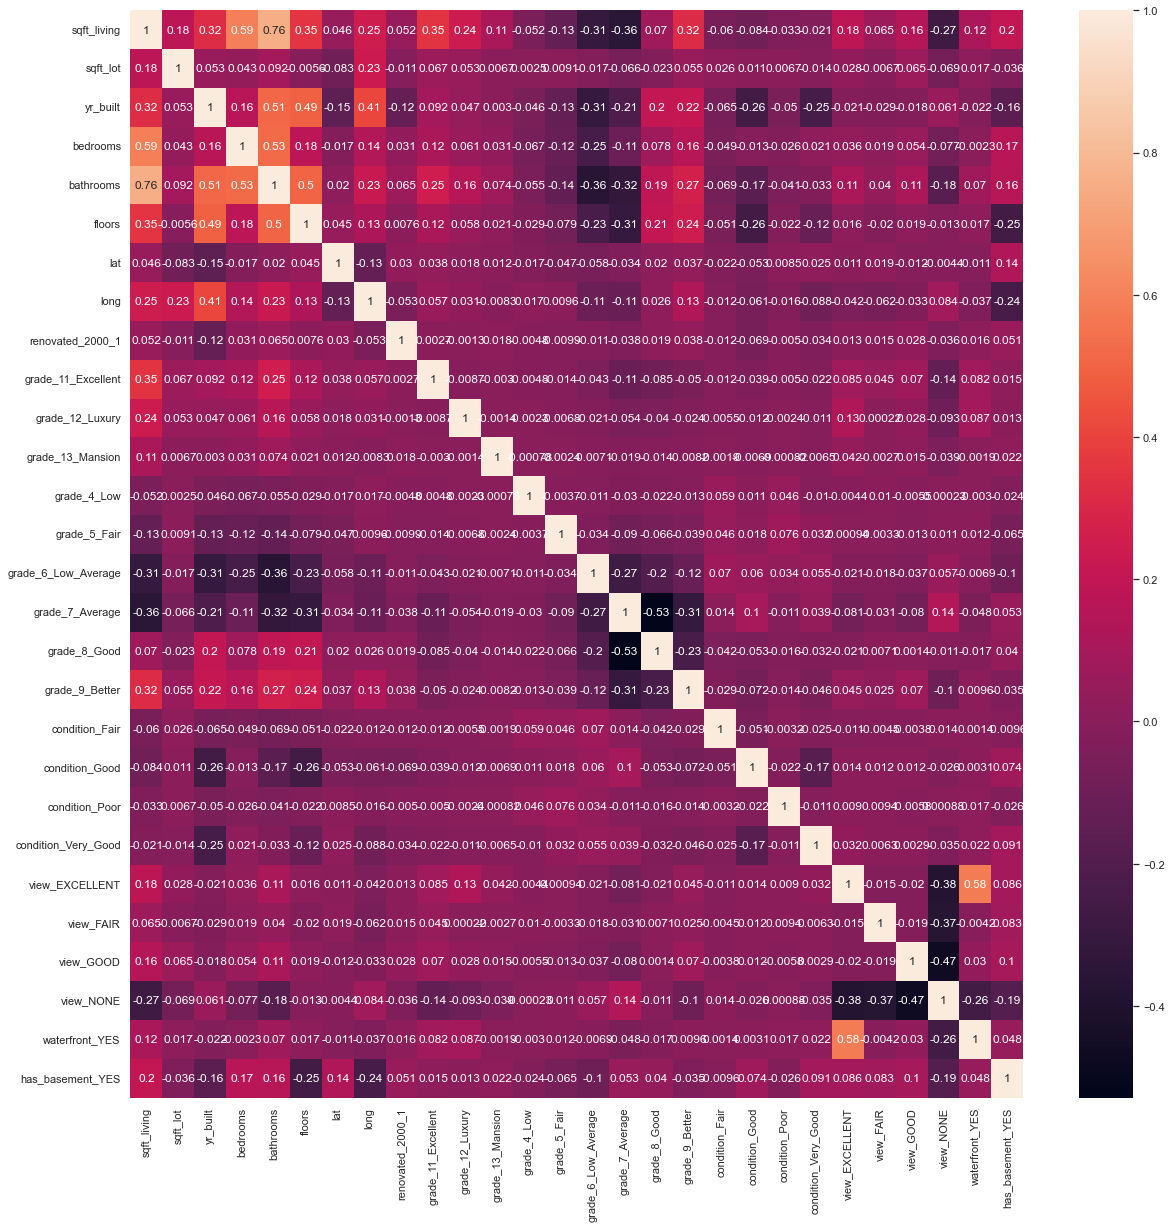

In [27]:
sns.heatmap(corr, annot = True);

# BAD v

There are still a lot of features, making this hard to look at and understand at a galnce. So we will use statsmodels' variance_inflation_factor to look at this information more clearly.

In [22]:
vif = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]
vif_scores = list(zip(X_2, vif))
vif_scores

[('sqft_living', 28.835477464403333),
 ('sqft_lot', 1.2174897718999493),
 ('yr_built', 8463.676528777034),
 ('bedrooms', 26.756524429725964),
 ('bathrooms', 29.828135217793417),
 ('floors', 15.7883219244218),
 ('lat', 118734.04418977769),
 ('long', 132899.7552265142),
 ('renovated_2000_1', 1.090149733880881),
 ('grade_11_Excellent', 1.393957741388614),
 ('grade_12_Luxury', 1.1473961415810088),
 ('grade_13_Mansion', 1.031104865367482),
 ('grade_4_Low', 1.0655854939986347),
 ('grade_5_Fair', 1.5071193776365372),
 ('grade_6_Low_Average', 4.805678328209165),
 ('grade_7_Average', 14.55682505773027),
 ('grade_8_Good', 8.166725435357435),
 ('grade_9_Better', 3.427015205212962),
 ('condition_Fair', 1.0322865770447565),
 ('condition_Good', 1.6540445483019413),
 ('condition_Poor', 1.015483531520584),
 ('condition_Very_Good', 1.2824478670590422),
 ('view_EXCELLENT', 1.8749482749415958),
 ('view_FAIR', 1.3376936206370766),
 ('view_GOOD', 1.5463914435941157),
 ('view_NONE', 22.677293068471702),
 ('

In [17]:
new_features = [x for x,vif in vif_scores if vif < 5]
new_features

['sqft_lot',
 'renovated_2000_1',
 'grade_11_Excellent',
 'grade_12_Luxury',
 'grade_13_Mansion',
 'grade_4_Low',
 'grade_5_Fair',
 'grade_6_Low_Average',
 'grade_9_Better',
 'condition_Fair',
 'condition_Good',
 'condition_Poor',
 'condition_Very_Good',
 'view_EXCELLENT',
 'view_FAIR',
 'view_GOOD',
 'waterfront_YES',
 'has_basement_YES']

Now that we have checked for uninfluential features as well as features potentially causing multicollinearity, we run the tests again.

In [18]:
X_3 = X_train[new_features]

model_3 = sm.OLS(y, sm.add_constant(X_3)).fit()
model_3.summary()

C:\Users\moola\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     765.3
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        11:29:33   Log-Likelihood:            -2.2466e+05
No. Observations:               16150   AIC:                         4.494e+05
Df Residuals:                   16131   BIC:                         4.495e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 4.34e+05   3401.860    127.587      0.000    4.27e+05    4.41e+05
sqft_lot                0.2662      0.054      4.948      0.000       0.161       0.372
renovated_2000_1     2.341e+05   1.59e+04     14.707      0.000    2.03e+05    2.65e+05
grade_11_Excellent   9.206e+05    1.6e+04     57.622      0.000    8.89e+05    9.52e+05
grade_12_Luxury      1.477e+06   3.33e+04     44.403      0.000    1.41e+06    1.54e+06
grade_13_Mansion     2.226e+06   9.44e+04     23.573      0.000    2.04e+06    2.41e+06
grade_4_Low         -2.514e+05   5.98e+04     -4.202      0.000   -3.69e+05   -1.34e+05
grade_5_Fair        -2.423e+05   2.01e+04    -12.045      0.000   -2.82e+05   -2.03e+05
grade_6_Low_Average -1.791e+05   7387.765    -24.245      0.000   -1.94e+05   -1.65e+05
grade_9_Better        2.53e+05   6603.723     38.314      0.000     2.4e+05    2.66e+05
condition_Fair      -6.843e+04   2.48e+04     -2.755      0.006   -1.17e+05   -1.97e+04
condition_Good         1.3e+04   4931.033      2.637      0.008    3338.578    2.27e+04
condition_Poor      -2.337e+04   5.72e+04     -0.409      0.683   -1.35e+05    8.87e+04
condition_Very_Good  1.066e+05   8028.647     13.281      0.000    9.09e+04    1.22e+05
view_EXCELLENT       4.547e+05   2.12e+04     21.485      0.000    4.13e+05    4.96e+05
view_FAIR            1.991e+05   1.75e+04     11.376      0.000    1.65e+05    2.33e+05
view_GOOD            2.506e+05    1.4e+04     17.900      0.000    2.23e+05    2.78e+05
waterfront_YES       5.696e+05   3.07e+04     18.553      0.000    5.09e+05     6.3e+05
has_basement_YES     8.282e+04   4455.769     18.588      0.000    7.41e+04    9.16e+04
==============================================================================
Omnibus:                     9756.988   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           223959.294
Skew:                           2.485   Prob(JB):                         0.00
Kurtosis:                      20.553   Cond. No.                     1.89e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This has actually reduced our R-Squared value, which is the opposite of what we would hope for. Nonetheless, multicollinear values had to be removed to prevent our model from being improperly trained for our test dataset.

## Final Model Interpretation

In [ ]:
X_train_final = X_train[new_features]
X_test_final = X_test[new_features]

In [ ]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train_final, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test_final, y_test)

The final model's score indicates that it is about 59% accurate.

Next we investigate if our model violates each of the assumptions of linear regression:

### Linearity

In [ ]:
sns.set(rc = {'figure.figsize':(5,5)})

In [ ]:
preds = final_model.predict(X_test_final)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")

This actually looks like it has a decently linear relationship, with no drastic outliers.

### Normality

In [ ]:
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

Our model also does not violate the Normality assumption.

### Multicollinearity
We already made sure that our model did not violate multicollinearity by removing features in the modeling phase. But we check again in the interest of good practice.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_train_final.values, i) for i in range(X_train_final.shape[1])]

pd.Series(vif, index=X_train_final.columns, name="Variance Inflation Factor")

None of these values are above 5, so our model does not violate the assumption of Multicollinearity, as expected.

### Homoscedasticity

In [ ]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test_final))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

Unfortunately, our model shows no Homoscedasticity at all. However, this could be caused by many different factors, and can be expected considering our model has only been trained with a 60% accuracy rate.

## Conclusions

This is not the strongest Linear Regression Model ever made. But it could certainly be used as a baseline predictor for assessing the value of homes in King County.

In [ ]:
print(pd.Series(final_model.coef_, index=X_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

### Interpretation

# ########view results in actual values!###############

The above shows how our algorithm uses each feature to make determinations about the target price. 

Some of the most positively correlated features according to the model are sqft_living, waterfront, and view_excellent. The coefficients (0.66 for view, 0.63 for waterfront, and 0.50 for sqft_living), are referring to the influence each of these features has on the value of a house, based on the data that has been transformed and standardized for scaling purposes of the model.

This holds true to common assumptions of what would be of value in a house. 

However, there also is a negative correlation to things like grade_5_Fair, and bedrooms_6, while the other grades and bedrooms numbers are positively correlated. This could be e due to rrors in the way our model was trained. 

### Next Steps
The reality is that there is a very broad range of factors that can influence any individual house sale. That being said, we could also explore more features based on commonplace observations. For example, our data contains information on when (in the case of our model, whether) each house was renovated, but not what elements of the house were renovated or what was changed about them. 

Additionally, we could run another analysis of the data using features like the grade, bathrooms, bedrooms, floors, etc. as continuous variables rather than categorical ones. This could lead to less cases like the one in which our model subtracts more value from a house for a 5("Fair") rating than a 4("Low") Rating. 

Furthermore, features like rating could use more exploration, and perhaps be removed from the dataset completely in future analyses.

We could also opt for a ground up approach, analyzing models trained on featuresets based on commonlplace assumptions about house values, instead of a purely data driven approach, which is prone to different kinds of errors.